In [1]:
#Import Libraries
import subprocess
import re
import pandas as pd
import os
import collections
import scipy.stats
import numpy as np
import scipy
import csv
import math
import seaborn as sns

from functools import reduce
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline
from pandas.tools.plotting import table
from scipy import interp
from sklearn import svm
from sklearn.svm import SVC
from sklearn.datasets import make_blobs, make_classification


from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, GridSearchCV, LeaveOneOut, train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, auc, roc_curve, precision_recall_curve, f1_score, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.multiclass import unique_labels
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

## Gene_Exprs, in particular PC

In [2]:
dset=pd.read_csv ("clintab_GMQL/gencode.gene.info.v22.tsv", delimiter='\t')
gruppo=dset.groupby(['gene_type'])
proteingroup=gruppo.get_group('protein_coding')
lista1=set(proteingroup['gene_id'])
#len(proteingroup)

In [3]:
dset_rna_res=pd.read_csv("clintab_GMQL/gene_exprs/res/res_new.csv", delimiter='\t')
dset_rna_senl=pd.read_csv("clintab_GMQL/gene_exprs/sl_32/sl_new.csv", delimiter='\t')
dset_rna_sens=pd.read_csv("clintab_GMQL/gene_exprs/ss_32/ss_new.csv", delimiter='\t')

In [8]:
lista=['ADAM12','BCCIP','BID','BLM','BMPR1B','CA9','CTBP2','CUZD1','DLL1','ELAVL1','FGFR2','FURIN',
       'GHSR','HTRA1','IQGAP1','PARK2','RECK','RNASET2','STOML2','TNFSF10','TPM2','UNC45A','UNC93A','URI1']
type(lista)

list

In [12]:
dset_res = dset_rna_res[dset_rna_res.ensemble_id.isin(lista1)]
protein_coding_res=pd.DataFrame(dset_res)
protein_coding_res['genes'] = protein_coding_res['ensemble_id']+'-'+ protein_coding_res['gene_symbol']
#protein_coding_res.head()
#protein_coding_res[protein_coding_res['patient'] == 'R_00000']

,patient,chrom,start,stop,ensemble_id,entrez_id,gene_symbol,fpkm_uq,fpkm
12204,R_00000,chr3,172445132,172448456,ENSG00000121853.3,2693.0,GHSR,0.000000e+00,0.000000
12205,R_00000,chr3,172505507,172523507,ENSG00000121858.9,8743.0,TNFSF10,3.172900e+05,12.302505
14091,R_00000,chr4,94757967,95158448,ENSG00000138696.9,658.0,BMPR1B,1.701562e+05,6.597585
21203,R_00000,chr6,161347419,162727771,ENSG00000185345.17,5071.0,PARK2,4.771713e+03,0.185017
21254,R_00000,chr6,166929503,166957191,ENSG00000026297.14,8635.0,RNASET2,4.611639e+05,17.881028
21266,R_00000,chr6,167271168,167316019,ENSG00000112494.8,54346.0,UNC93A,4.811787e+03,0.186571
21322,R_00000,chr6,170282205,170306565,ENSG00000198719.8,28514.0,DLL1,1.851837e+04,0.718026
27285,R_00000,chr9,35099775,35103195,ENSG00000165283.14,30968.0,STOML2,1.478477e+06,57.326029
27307,R_00000,chr9,35673855,35681159,ENSG00000107159.11,768.0,CA9,1.940275e+05,7.523165
27308,R_00000,chr9,35681991,35691020,ENSG00000198467.12,7169.0,TPM2,1.651215e+06,64.023715


In [5]:
dset_senl = dset_rna_senl[dset_rna_senl.ensemble_id.isin(lista1)]
protein_coding_senl=pd.DataFrame(dset_senl)
protein_coding_senl['genes'] = protein_coding_senl['ensemble_id']+'-'+ protein_coding_senl['gene_symbol']

In [6]:
dset_sens = dset_rna_sens[dset_rna_sens.ensemble_id.isin(lista1)]
protein_coding_sens=pd.DataFrame(dset_sens)
protein_coding_sens['genes'] = protein_coding_sens['ensemble_id']+'-'+ protein_coding_sens['gene_symbol']
#protein_coding_sens.head()

In [7]:
resdf=protein_coding_res.pivot(index="patient", columns="genes", values="fpkm")
genes = resdf.columns.tolist()
#resdf.head()
#resdf.shape

In [44]:
senldf=protein_coding_senl.pivot(index="patient", columns="genes", values="fpkm")
senldf = senldf[genes]
#senldf.head()
#senldf.shape

In [45]:
sensdf=protein_coding_sens.pivot(index="patient", columns="genes", values="fpkm")
sensdf = sensdf[genes]
#sensdf.head()
#sensdf.shape

In [46]:
sendf=pd.concat([senldf, sensdf])

In [30]:
resdf_median = resdf.median(0)
senldf_median = senldf.median(0)
sensdf_median = sensdf.median(0)

In [47]:
resdf_median = resdf.median(0)
sendf_median = sendf.median(0)

In [48]:
pvalues = []
for gene in tqdm(genes):
    try:
        gene_pvalue = scipy.stats.mannwhitneyu(sendf[gene],resdf[gene]).pvalue
    except Exception:
        gene_pvalue = 1
       
    pvalues.append(gene_pvalue)
       
pvalues = pd.DataFrame({
    "gene": genes,
    "resistant_median": resdf_median.values,
    "sensitive_median": sendf_median.values,
    #"sensitive_long_median": senldf_median.values,
    #"sensitive_short_median": sensdf_median.values,
    "mannwhiteney_pvalue": pvalues
})

pvalues.head()

100%|██████████| 19814/19814 [00:08<00:00, 2357.18it/s]


,gene,resistant_median,sensitive_median,mannwhiteney_pvalue
0,ENSG00000000003.13-TSPAN6,15.537437,16.955365,0.180650
1,ENSG00000000005.5-TNMD,0.038791,0.068842,0.030820
2,ENSG00000000419.11-DPM1,42.847159,42.284020,0.342092
3,ENSG00000000457.12-SCYL3,1.939755,2.002856,0.200821
4,ENSG00000000460.15-C1orf112,1.415162,1.655893,0.034242


## Selection from p_value

In [22]:
threshold = 0.0005

significant_genes = pvalues[(pvalues.mannwhiteney_pvalue < threshold)].copy()
significant_genes = significant_genes.sort_values("mannwhiteney_pvalue", ascending=True)
print(significant_genes.shape[0])

26


In [23]:
names=[]

for x in ["-".join(x.strip().split("-")[1:])  for x in (significant_genes['gene'])]:
    names.append(x)   
    
significant_genes['gene_symbol']=names
significant_genes=pd.DataFrame(significant_genes)
significant_genes.head()
#significant_genes.to_csv('new_data/gene_exprs/SS_SL_last.csv', sep=',', header=True, index=False)
#significant_genes.to_csv('new_data/gene_exprs/r_ss_pv2.csv', sep=',', header=True, index=False)
#significant_genes.to_csv('new_data/gene_exprs/sl_ss_pv2.csv', sep=',', header=True, index=False)

,gene,resistant_median,sensitive_long_median,mannwhiteney_pvalue,gene_symbol
1511,ENSG00000081026.17-MAGI3,2.004508,3.137310,0.000053,MAGI3
7361,ENSG00000137393.9-RNF144B,8.484803,15.532160,0.000065,RNF144B
6820,ENSG00000134504.11-KCTD1,6.369336,10.695657,0.000086,KCTD1
9336,ENSG00000151812.13-SLC35F4,0.005034,0.015873,0.000091,SLC35F4
7359,ENSG00000137364.4-TPMT,10.070143,13.108867,0.000117,TPMT


In [ ]:
lista=list(significant_genes['gene_symbol'])
type(lista)

In [ ]:
protein_coding_sens.head()

In [ ]:
x = protein_coding_sens[protein_coding_sens.gene_symbol.isin(lista)]
y=pd.DataFrame(x)
y.to_csv('new_data/gene_exprs/R_SL_last.csv', sep=',', header=True, index=False)

In [24]:
column=significant_genes['gene']
column.head()

1511      ENSG00000081026.17-MAGI3
7361     ENSG00000137393.9-RNF144B
6820      ENSG00000134504.11-KCTD1
9336    ENSG00000151812.13-SLC35F4
7359        ENSG00000137364.4-TPMT
Name: gene, dtype: object

## Bonferroni, len(p_values)

In [ ]:
p_value_corr =[]

for index, value in tqdm(pvalues['gene'].iteritems()): 
        
        somma=len(pvalues)
        p_value=pvalues[pvalues['gene']==value]['mannwhiteney_pvalue'].iloc[0]
        p_value_corr.append(somma*p_value)
        #print(p_value_corr)
print(len(p_value_corr))

In [ ]:
id_name=[]
gene_name=[]

for x in ["-".join(x.strip().split("-")[:1])  for x in (pvalues['gene'])]:
    id_name.append(x)   
for x in ["-".join(x.strip().split("-")[1:])  for x in (pvalues['gene'])]:
    gene_name.append(x) 
    
pvalues['ensemble_id']=id_name
pvalues['gene_symbol']=gene_name
pvalues=pd.DataFrame(pvalues)

In [ ]:
pvalues['p_value_corr']=p_value_corr
#pvalues.head()

In [ ]:
threshold = 0.05

significant_genes_corr = pvalues[(pvalues.p_value_corr < threshold)].copy()
significant_genes_corr = significant_genes_corr.sort_values("mannwhiteney_pvalue", ascending=True)
significant_genes_corr=pd.DataFrame(significant_genes_corr)
print(significant_genes_corr.shape[0])
significant_genes_corr.head()

In [ ]:
column=significant_genes_corr['gene']
column.head()

## Bonferroni, len(patients)

In [49]:
threshold = 0.005

significant_genes = pvalues[(pvalues.mannwhiteney_pvalue < threshold)].copy()
significant_genes = significant_genes.sort_values("mannwhiteney_pvalue", ascending=True)
print(significant_genes.shape[0])

352


In [50]:
id_name=[]
gene_name=[]

for x in ["-".join(x.strip().split("-")[:1])  for x in (significant_genes['gene'])]:
    id_name.append(x)   
for x in ["-".join(x.strip().split("-")[1:])  for x in (significant_genes['gene'])]:
    gene_name.append(x) 
    
significant_genes['ensemble_id']=id_name
significant_genes['gene_symbol']=gene_name
significant_genes=pd.DataFrame(significant_genes)
significant_genes.head()

,gene,resistant_median,sensitive_median,mannwhiteney_pvalue,ensemble_id,gene_symbol
2166,ENSG00000100084.13-HIRA,2.692785,3.473444,0.000015,ENSG00000100084.13,HIRA
9755,ENSG00000155660.9-PDIA4,74.589427,104.633680,0.000018,ENSG00000155660.9,PDIA4
13251,ENSG00000173335.4-CST9,0.012090,0.062734,0.000019,ENSG00000173335.4,CST9
603,ENSG00000044574.7-HSPA5,107.221321,141.533894,0.000040,ENSG00000044574.7,HSPA5
14675,ENSG00000182253.13-SYNM,0.305599,0.493554,0.000041,ENSG00000182253.13,SYNM


In [51]:
n_res=len(protein_coding_res['patient'].unique())
n_sens=len(protein_coding_sens['patient'].unique())
n_senl=len(protein_coding_senl['patient'].unique())
n_sen=n_sens+n_senl

In [52]:
p_value_corr =[]

for index, value in tqdm(significant_genes['gene'].iteritems()): 
        
        somma=n_sen+n_res
        #somma=n_res+n_sens
        p_value=pvalues[pvalues['gene']==value]['mannwhiteney_pvalue'].iloc[0]
        p_value_corr.append(somma*p_value)
        #print(p_value_corr)
print(len(p_value_corr))

352it [00:00, 409.74it/s]

352


In [53]:
significant_genes['p_value_corr']=p_value_corr

In [54]:
threshold = 0.05

significant_genes_corr = significant_genes[(significant_genes.p_value_corr < threshold)].copy()
significant_genes_corr = significant_genes_corr.sort_values("mannwhiteney_pvalue", ascending=True)
significant_genes_corr=pd.DataFrame(significant_genes_corr)
print(significant_genes_corr.shape[0])
significant_genes_corr.head()

20


,gene,resistant_median,sensitive_median,mannwhiteney_pvalue,ensemble_id,gene_symbol,p_value_corr
2166,ENSG00000100084.13-HIRA,2.692785,3.473444,0.000015,ENSG00000100084.13,HIRA,0.002961
9755,ENSG00000155660.9-PDIA4,74.589427,104.633680,0.000018,ENSG00000155660.9,PDIA4,0.003690
13251,ENSG00000173335.4-CST9,0.012090,0.062734,0.000019,ENSG00000173335.4,CST9,0.003858
603,ENSG00000044574.7-HSPA5,107.221321,141.533894,0.000040,ENSG00000044574.7,HSPA5,0.008130
14675,ENSG00000182253.13-SYNM,0.305599,0.493554,0.000041,ENSG00000182253.13,SYNM,0.008220


In [ ]:
lista=list(significant_genes_corr['gene_symbol'])
type(lista)

In [ ]:
lista

In [ ]:
x = protein_coding_sens[protein_coding_sens.gene_symbol.isin(lista)]
y=pd.DataFrame(x)
y.head(21)
y.to_csv('new_data/gene_exprs/R_Stot_last.csv', sep=',', header=True, index=False)

In [ ]:
#significant_genes.to_csv('new_data/gene_exprs/r_sl_pv2.csv', sep=',', header=True, index=False)
#significant_genes.to_csv('new_data/gene_exprs/r_ss_pv2.csv', sep=',', header=True, index=False)
#significant_genes.to_csv('new_data/gene_exprs/sl_ss_pv2.csv', sep=',', header=True, index=False)

In [55]:
column=significant_genes_corr['gene']
column.head()

2166     ENSG00000100084.13-HIRA
9755     ENSG00000155660.9-PDIA4
13251     ENSG00000173335.4-CST9
603      ENSG00000044574.7-HSPA5
14675    ENSG00000182253.13-SYNM
Name: gene, dtype: object

In [ ]:
lista=column.values
np.save("gene_exprs_stot_vs_res.npy", lista)

## FDR 

In [ ]:
from statsmodels.stats.multitest import fdrcorrection

In [ ]:
p_sorted=pvalues.sort_values(by='mannwhiteney_pvalue')

In [ ]:
pvalues_FDR=pvalues['mannwhiteney_pvalue']
p_corrected=fdrcorrection(pvalues_FDR, alpha=0.05, method='indep')
w=p_corrected[1]

p_sorted['p_value_corr_bh']=w
p_sorted.head()

In [ ]:
threshold = 0.05

significant_genes_bh = p_sorted[(p_sorted.p_value_corr_bh < threshold)].copy()
significant_genes_bh = significant_genes_bh.sort_values("p_value_corr_bh", ascending=True)
significant_genes_bh=pd.DataFrame(significant_genes_bh)
print(significant_genes_bh.shape[0])

In [ ]:
column=significant_genes_bh['gene']
column.head()

## Benjamini-Hochberg, len(patients)

In [ ]:
p_sorted=pvalues.sort_values(by='mannwhiteney_pvalue')

In [ ]:
a=p_sorted['mannwhiteney_pvalue'].get_values()

In [ ]:
enumerate(a)

In [ ]:
num_total_tests=n_sen+n_res #inserisci il num pazienti

In [ ]:
def calc_benjamini_hochberg_corrections(p_values, num_total_tests):
   
    p_value_bh = []
    for i, p_value in enumerate(p_values):
        bh_value = p_value * num_total_tests / (i + 1)
        p_value_bh.append(bh_value)
    return (p_value_bh)

In [ ]:
p_value_corr_bh=calc_benjamini_hochberg_corrections(a, num_total_tests)

In [ ]:
p_sorted['p_value_corr_bh']=p_value_corr_bh

In [ ]:
p_sorted.head()

In [ ]:
threshold = 0.05

significant_genes_bh = p_sorted[(p_sorted.p_value_corr_bh < threshold)].copy()
significant_genes_bh = significant_genes_bh.sort_values("p_value_corr_bh", ascending=True)
print(significant_genes_bh.shape[0])

In [ ]:
id_name=[]
gene_name=[]

for x in ["-".join(x.strip().split("-")[:1])  for x in (significant_genes_bh['gene'])]:
    id_name.append(x)   
for x in ["-".join(x.strip().split("-")[1:])  for x in (significant_genes_bh['gene'])]:
    gene_name.append(x) 
    
significant_genes_bh['ensemble_id']=id_name
significant_genes_bh['gene_symbol']=gene_name
significant_genes_bh=pd.DataFrame(significant_genes_bh)
significant_genes_bh.head()

In [ ]:
#significant_genes_bh.to_csv('new_data/gene_exprs/sl_ss_bh_ge.csv', sep=',', header=True, index=False)

In [ ]:
column=significant_genes_bh['gene']
column.head()

## Classification

In [56]:
res_selected=resdf[column]
res_selected["label"]=1
res_selected.shape

/home/lalli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(60, 21)

In [26]:
senl_selected=senldf[column]
senl_selected["label"]=0
senl_selected.shape

/home/lalli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(34, 27)

In [40]:
sens_selected=sensdf[column]
sens_selected["label"]=0
sens_selected.shape

/home/lalli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(107, 41)

In [57]:
sen_selected=sendf[column]
sen_selected["label"]=0
sen_selected.shape

/home/lalli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(141, 21)

In [58]:
#concatenated=pd.concat([res_selected, senl_selected])
#concatenated=pd.concat([res_selected, sens_selected])
#concatenated=pd.concat([senl_selected, sens_selected])
concatenated=pd.concat([res_selected, sen_selected])

In [59]:
X=concatenated[concatenated.columns[:-1]].values
y=concatenated[concatenated.columns[-1]].values

In [ ]:
precision=[]
recall=[]

#loo = LeaveOneOut()
#loo.get_n_splits(X)
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=20, random_state=36851234)
for train_index, test_index in (rskf.split(X, y)) :
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index] 
    y_train, y_test = y[train_index], y[test_index]

clf = svm.SVC(kernel='rbf', class_weight='balanced')
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

    clf.fit(X_train, y_train)
    y_predict=clf.predict(X_test)
    
    precision.append(precision_score(y_test, y_predict))
    recall.append(recall_score(y_test, y_predict))

In [ ]:
#kf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=36851234)
kf = StratifiedKFold(n_splits=10)
recall=[]
precision=[]
accuracy=[]
fscore=[]
scores=['true_res', 'false_senl', 'true_senl', 'false_res', 'accuracy', 'precision', 'recall', 'f1_score']
performance=pd.DataFrame(index=np.arange(10), columns=scores)
i=0
for train_index, test_index in kf.split(X, y):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    '''X=pd.DataFrame(x_train, columns=features)
    model= RandomForestClassifier(n_estimators=200, max_depth=15, class_weight='balanced')
    model.fit(X,y_train)
    f=feat_importances.nlargest(15).index
    x_train=X[f].values
    X_t=pd.DataFrame(x_test, columns=features)
    x_test=X_t[f]'''
    
    print('real')
    print(y_test)
    
    clf = RandomForestClassifier(n_estimators=200, max_depth=15, class_weight='balanced')
    #clf=KNeighborsClassifier(n_neighbors=3, metric='manhattan')
    #clf = AdaBoostClassifier(n_estimators=200, base_estimator=DecisionTreeClassifier(max_depth=5),random_state=0)
    #clf=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
    #clf = svm.SVC(kernel='rbf', C=100, probability=True, gamma = 0.0001, class_weight='balanced', random_state=42)
    
    clf.fit(x_train, y_train)
    y_pred=clf.predict(x_test)
    print('predicted')
    print(y_pred)
    recall.append(recall_score(y_test, y_pred))
    precision.append(precision_score(y_test, y_pred))
    accuracy.append(accuracy_score(y_test, y_pred))
    fscore.append(f1_score(y_test, y_pred))
    performance.iloc[i]['accuracy']=accuracy_score(y_test, y_pred)
    performance.iloc[i]['precision']=precision_score(y_test, y_pred)
    performance.iloc[i]['recall']=recall_score(y_test, y_pred)
    performance.iloc[i]['f1_score']=f1_score(y_test, y_pred)
    c_matrix=confusion_matrix(y_test, y_pred)
    performance.iloc[i]['true_sens']=c_matrix[0][0]
    performance.iloc[i]['false_sens']=c_matrix[1][0]
    performance.iloc[i]['true_res']=c_matrix[1][1]
    performance.iloc[i]['false_res']=c_matrix[0][1]
    print (i)
    i=i+1

In [ ]:
print('Average precision: ', np.mean(precision))
print('Average recall: ', np.mean(recall))
print('Average accuracy: ', np.mean(accuracy))
print('Average f1_score: ', np.mean(fscore))
print('Standard_deviation precision: ', np.std(precision))
print('Standard_deviation recall: ', np.std(recall))
print('Standard_deviation accuracy: ', np.std(accuracy))
print('Standard_deviation f1_score: ', np.std(fscore))

In [ ]:
performance

## Data visualization

In [ ]:
def my_PCA(data, features, labels, i, j):
    #x = data.loc[:, features].values
    x = StandardScaler().fit_transform(data)
    
    pca= PCA(n_components=3)
    p_comp=pca.fit_transform(x)
    #p_comp = TSNE(n_components=2, perplexity=70, n_iter=2500).fit_transform(x)
    p_comp=p_comp[:, [i,j]]

    principalDf = pd.DataFrame(data = p_comp
             , columns = ['principal component '+str(i), 'principal component '+str(j)])
    finalDf= pd.concat([principalDf, pd.Series(labels)], axis=1)
    
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component '+str(i+1), fontsize = 15)
    ax.set_ylabel('Principal Component '+str(j+1), fontsize = 15)
    ax.set_title('2 Component PCA', fontsize = 20)
    



    targets = ['Sensitive_long', 'Sensitive_short']
    colors = ['b', 'r']
    for target, color in zip(targets,colors):
        t=0
        if target == 'Sensitive_short':
            t=1
        #if target == 'Sensitive_long':
         #   t=2
        indicesToKeep = finalDf[0] == t
        ax.scatter(finalDf.loc[indicesToKeep, 'principal component '+str(i)]
                   , finalDf.loc[indicesToKeep, 'principal component '+str(j)]
                   , c = color
                   , s = 50)
    ax.legend(targets)
    ax.grid()

In [ ]:
my_PCA(X, concatenated.columns, y, 0, 2)
#plt.savefig('my_PCA_res_sens_12.png')
my_PCA

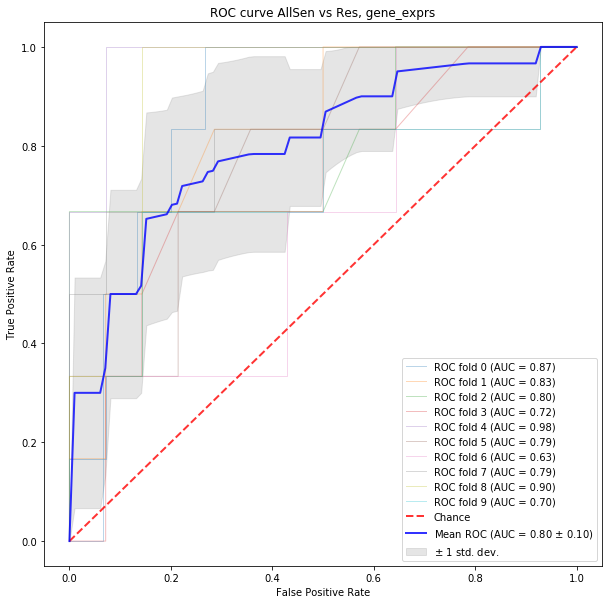

In [60]:
# ROC curve
classifier = RandomForestClassifier(n_estimators=200, max_depth=15, class_weight='balanced')
#classifier = AdaBoostClassifier(n_estimators=200, base_estimator=DecisionTreeClassifier(max_depth=5),random_state=0)
#classifier = svm.SVC(kernel='rbf', C=10, probability=True, gamma = 0.0001, class_weight='balanced', random_state=42)
#classifier=KNeighborsClassifier(n_neighbors=3, metric='manhattan')
#classifier= LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
#cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=36851234)
cv = StratifiedKFold(n_splits=10)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))
i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')


plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve AllSen vs Res, gene_exprs')
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          #fancybox=True, shadow=True, ncol=5)
plt.legend(loc='lower right')
plt.savefig('1.png')

In [ ]:
k_fold = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=36851234)
y_real = []
y_proba = []
#predictor= RandomForestClassifier(n_estimators=200, max_depth=15, class_weight='balanced')
#predictor = AdaBoostClassifier(n_estimators=200, base_estimator=DecisionTreeClassifier(max_depth=5),random_state=0)
predictor = svm.SVC(kernel='rbf', C=100, probability=True, gamma = 0.0001, class_weight='balanced', random_state=42)
#predictor = KNeighborsClassifier(n_neighbors=3, metric='manhattan')
#predictor = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=36851234)


tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))
i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')


plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('ROC curve Res vs Senl')

#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
         # fancybox=True, shadow=True, ncol=5)
#plt.savefig('ROC_Res_vs_SenS.png')
#predictor = AdaBoostClassifier(n_estimators=200, base_estimator=DecisionTreeClassifier(max_depth=5),random_state=0)
precision_array = []
threshold_array=[]
recall_array = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))
for i, (train_index, test_index) in enumerate(k_fold.split(X, y)):
    Xtrain, Xtest = X[train_index], X[test_index]
    ytrain, ytest = y[train_index], y[test_index]
    predictor.fit(Xtrain, ytrain)
    pred_proba = predictor.predict_proba(Xtest)
    precision_fold, recall_fold, thresh = precision_recall_curve(ytest, pred_proba[:,1])
    precision_fold, recall_fold, thresh = precision_fold[::-1], recall_fold[::-1], thresh[::-1]  # reverse order of results
    thresh = np.insert(thresh, 0, 1.0)
    precision_array = interp(recall_array, recall_fold, precision_fold)
    threshold_array = interp(recall_array, recall_fold, thresh)
    pr_auc = auc(recall_array, precision_array)

    lab_fold = 'Fold %d AUC=%.4f' % (i+1, pr_auc)
    plt.plot(recall_fold, precision_fold, alpha=0.3, label=lab_fold)
    y_real.append(ytest)
    y_proba.append(pred_proba[:,1])
    
y_real = np.concatenate(y_real)
y_proba = np.concatenate(y_proba)
precision, recall, thr = precision_recall_curve(y_real, y_proba)
lab = 'Overall AUC=%.4f' % (auc(recall, precision))

plt.plot(recall, precision, lw=2,color='red', label=lab)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

mean_precision = np.mean(precision_array)
std_precision = np.std(precision_array)
plt.fill_between(recall, precision + std_precision, precision - std_precision, alpha=0.3, linewidth=0, color='grey')
#plt.show()
#plt.title('PR curve Res vs SenS')
#plt.savefig('PR curve Res vs Senl_RF.png')

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
c_matrix=confusion_matrix(y_test, y_pred)
c_matrix